<a href="https://colab.research.google.com/github/Andrea-1704/Pytorch_Geometric_tutorial/blob/main/train_model_baseline_f1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obiettivo
L’idea è rendere il modello più esplicitamente ibrido, cioè combinare in parallelo le informazioni grezze (tabellari) e quelle relazionali (da GNN), invece che solo in sequenza.


# Libraries to install

In [2]:
# !pip install torch==2.6.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# !pip install pyg-lib -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu118.html
# !pip install torch-geometric==2.6.0 -f https://data.pyg.org/whl/torch-2.6.0+cu118.html

# !pip install pytorch_frame[full]==1.2.2
# !pip install relbench[full]==1.0.0

# Import

In [3]:
import os
import torch
import relbench
import numpy as np
from torch.nn import BCEWithLogitsLoss, L1Loss
from relbench.datasets import get_dataset
from relbench.tasks import get_task
import math
from tqdm import tqdm
import torch_geometric
import torch_frame
from torch_geometric.seed import seed_everything
from relbench.modeling.utils import get_stype_proposal
from collections import defaultdict
import requests
from io import StringIO
from torch_frame.config.text_embedder import TextEmbedderConfig
from relbench.modeling.graph import make_pkey_fkey_graph
from torch.nn import BCEWithLogitsLoss
import copy
from typing import Any, Dict, List
from torch import Tensor
from torch.nn import Embedding, ModuleDict
from torch_frame.data.stats import StatType
from torch_geometric.data import HeteroData
from torch_geometric.nn import MLP
from torch_geometric.typing import NodeType
from relbench.modeling.nn import HeteroEncoder, HeteroGraphSAGE, HeteroTemporalEncoder
from relbench.modeling.graph import get_node_train_table_input, make_pkey_fkey_graph
from torch_geometric.loader import NeighborLoader
import pyg_lib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#Utility functions

In [4]:
@torch.no_grad()
def alignment_check(loader: NeighborLoader, expected_node_ids: torch.Tensor):
    node_id_list = []

    for batch in loader:
        batch = batch.to(device)

        node_id_list.append(batch[task.entity_table].n_id.cpu())

    actual_node_ids = torch.cat(node_id_list, dim=0)

    assert len(actual_node_ids) == len(expected_node_ids), "Mismatch nella lunghezza"

    if not torch.equal(actual_node_ids, expected_node_ids):
        raise ValueError("Ordine dei nodi predetti diverso da val_table!")

    return

In [5]:
def evaluate_performance(pred: np.ndarray, target_table, metrics) -> dict:
    """Custom evaluation function to replace task.evaluate."""
    target = target_table.df[task.target_col].to_numpy()

    if len(pred) != len(target):
        raise ValueError(
            f"The length of pred and target must be the same (got "
            f"{len(pred)} and {len(target)}, respectively)."
        )

    results = {}
    for metric_fn in metrics:
        if metric_fn.__name__ == "rmse":
            results["rmse"] = np.sqrt(np.mean((target - pred)**2))
        else:
            results[metric_fn.__name__] = metric_fn(target, pred)

    return results

In [6]:
import numpy as np

def evaluate_on_train_during_training() -> float:
    model.eval()
    pred_list, target_list = [], []

    for batch in loader_dict["train"]:
        batch = batch.to(device)
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
        target_list.append(batch[task.entity_table].y.detach().cpu())

    pred_all = torch.cat(pred_list, dim=0).numpy()
    target_all = torch.cat(target_list, dim=0).numpy()

    mae = np.mean(np.abs(pred_all - target_all))
    return mae


In [7]:
def rmse(true, pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((true - pred)**2))

In [8]:
@torch.no_grad()
def evaluate_on_full_train(model, loader) -> float:
    model.eval()
    pred_list, target_list = [], []

    for batch in loader:
        batch = batch.to(device)
        pred = model(batch, task.entity_table)
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.cpu())
        target_list.append(batch[task.entity_table].y.cpu())

    pred_all = torch.cat(pred_list, dim=0).numpy()
    target_all = torch.cat(target_list, dim=0).numpy()

    mae = np.mean(np.abs(pred_all - target_all))
    return mae


In [9]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): Quanto aspettare senza miglioramenti prima di fermare.
            delta (float): Miglioramento minimo richiesto per considerare un miglioramento.
            verbose (bool): Se stampare informazioni.
            path (str): Dove salvare il modello migliore.
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.verbose = verbose
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss  # Perché vogliamo MINIMIZZARE la loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Salva il modello migliore'''
        if self.verbose:
            print(f'Validation loss migliorata ({self.val_loss_min:.6f} --> {val_loss:.6f}). Salvo modello...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# Dataset and task creation

In [10]:
dataset = get_dataset("rel-f1", download=True)
task = get_task("rel-f1", "driver-position", download=True)

train_table = task.get_table("train") #date  driverId  qualifying
val_table = task.get_table("val") #date  driverId  qualifying
test_table = task.get_table("test") # date  driverId

out_channels = 1
loss_fn = L1Loss()
# this is the mae loss and is used when have regressions tasks.
tune_metric = "mae"
higher_is_better = False

seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
root_dir = "./data"

db = dataset.get_db() #get all tables
col_to_stype_dict = get_stype_proposal(db)
#this is used to get the stype of the columns

100%|████████████████████████████████████████| 704k/704k [00:00<00:00, 687MB/s]
Unzipping contents of '/root/.cache/relbench/rel-f1/db.zip' to '/root/.cache/relbench/rel-f1/.'
100%|█████████████████████████████████████| 36.5k/36.5k [00:00<00:00, 44.2MB/s]
Unzipping contents of '/root/.cache/relbench/rel-f1/tasks/driver-position.zip' to '/root/.cache/relbench/rel-f1/tasks/.'


cuda
Loading Database object from /root/.cache/relbench/rel-f1/db...
Done in 0.05 seconds.


# Embedder

In [11]:
class LightweightGloveEmbedder:
    def __init__(self, device=None):
        self.device = device
        self.embeddings = defaultdict(lambda: np.zeros(300))
        self._load_embeddings()

    def _load_embeddings(self):
      try:
          path = "glove.6B.300d.txt"
          with open(path, encoding="utf-8") as f:
              for line in f:
                  parts = line.strip().split()
                  word = parts[0]
                  vector = np.array(parts[1:], dtype=np.float32)
                  self.embeddings[word] = vector
          print(f"Loaded {len(self.embeddings)} GloVe embeddings.")
      except Exception as e:
          print(f"Failed to load GloVe: {e}")

    def __call__(self, sentences):
        results = []
        for text in sentences:
            words = text.lower().split()
            vectors = [self.embeddings[w] for w in words if w in self.embeddings]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                print("non trovato")
                print(f"Numero parole in embedding: {len(self.embeddings)}")

                avg_vector = np.zeros(300)
            results.append(avg_vector)

        tensor = torch.tensor(np.array(results), dtype=torch.float32)
        return tensor.to(self.device) if self.device else tensor

In [12]:
text_embedder_cfg = TextEmbedderConfig(
    text_embedder=LightweightGloveEmbedder(device=device), batch_size=256
)

data, col_stats_dict = make_pkey_fkey_graph(
    db,
    col_to_stype_dict=col_to_stype_dict,
    text_embedder_cfg=text_embedder_cfg,
    cache_dir=os.path.join(
        root_dir, f"rel-f1_materialized_cache"
    ),
)

Failed to load GloVe: [Errno 2] No such file or directory: 'glove.6B.300d.txt'


Embedding raw data in mini-batch:   0%|          | 0/1 [00:00<?, ?it/s]

non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 376.78it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 432.58it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 551.08it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 176.79it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 216.12it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 1/1 [00:00<00:00, 371.77it/s]
/usr/local/lib/python3.11/dist-packages/torch_frame/data/stats.py:177: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ser = pd.to_datetime(ser, format=time_format)


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 433.16it/s]
/usr/local/lib/python3.11/dist-packages/torch_frame/data/mapper.py:291: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ser = pd.to_datetime(ser, format=self.format, errors='coerce')


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch:   0%|          | 0/4 [00:00<?, ?it/s]

non trovato

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 364.60it/s]



Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non

Embedding raw data in mini-batch:   0%|          | 0/4 [00:00<?, ?it/s]

non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 351.08it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 399.23it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 384.01it/s]


non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

Embedding raw data in mini-batch: 100%|██████████| 4/4 [00:00<00:00, 390.21it/s]

non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embedding: 0
non trovato
Numero parole in embed

# Graph Loader

In [13]:
loader_dict = {}

for split, table in [
    ("train", train_table),
    ("val", val_table),
    ("test", test_table),
]:
    table_input = get_node_train_table_input(
        table=table,
        task=task,
    )

    entity_table = table_input.nodes[0]

    loader_dict[split] = NeighborLoader(
        data,
        num_neighbors=[
            128 for i in range(2) #################################
        ],
        time_attr="time",
        input_nodes=table_input.nodes,
        input_time=table_input.time,
        transform=table_input.transform,
        batch_size=512,
        temporal_strategy="uniform",
        shuffle=split == "train",
        num_workers=0,
        persistent_workers=False,
    )

In [14]:
# # Loader per valutazione sul train set (senza shuffle)
# eval_train_loader = NeighborLoader(
#     data,
#     num_neighbors=[128 for _ in range(2)],
#     time_attr="time",
#     input_nodes=get_node_train_table_input(train_table, task).nodes,
#     input_time=get_node_train_table_input(train_table, task).time,
#     transform=get_node_train_table_input(train_table, task).transform,
#     batch_size=512,
#     temporal_strategy="uniform",
#     shuffle=False,  # nb
#     num_workers=0,
#     persistent_workers=False,
# )


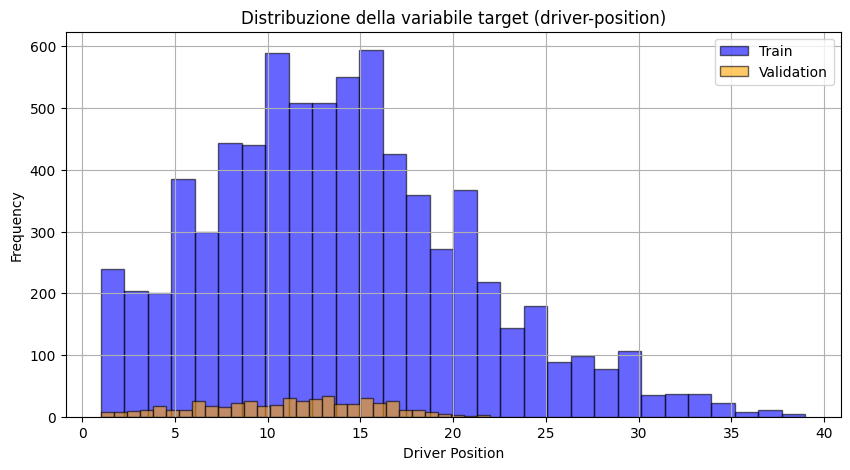

In [15]:
import matplotlib.pyplot as plt

train_targets = train_table.df[task.target_col]
val_targets = val_table.df[task.target_col]

plt.figure(figsize=(10, 5))
plt.hist(train_targets, bins=30, alpha=0.6, label='Train', color='blue', edgecolor='black')
plt.hist(val_targets, bins=30, alpha=0.6, label='Validation', color='orange', edgecolor='black')
plt.legend()
plt.xlabel("Driver Position")
plt.ylabel("Frequency")
plt.title("Distribuzione della variabile target (driver-position)")
plt.grid(True)
plt.show()


Il training set ha una distribuzione ampia di driver-position, da 1 fino a 35–40, con una concentrazione tra 10 e 20.

Il validation set è estremamente sbilanciato:

È molto più piccolo (ci sta)

Ma soprattutto è fortemente concentrato tra posizione 10 e 20, con pochissimi esempi in altre zone.

Il modello ha un training set con valori molto più difficili e sparsi, mentre la validazione lavora solo su una piccola porzione della distribuzione.

Questo spiega il perché:
Il MAE su train è più alto: i dati sono più complessi.

Il MAE su val è più basso: è come se stesse testando solo su un subset facile.

In [16]:
# qui i parametri di train_table, val_table, test_table, task e data sono
#parametri globali

def loader_dict_fn(batch_size, num_neighbours):
    loader_dict = {}

    for split, table in [
        ("train", train_table),
        ("val", val_table),
        ("test", test_table),
    ]:
        table_input = get_node_train_table_input(
            table=table,
            task=task,
        )

        loader_dict[split] = NeighborLoader(
            data,
            num_neighbors=[num_neighbours for _ in range(2)],
            time_attr="time",
            input_nodes=table_input.nodes,
            input_time=table_input.time,
            transform=table_input.transform,
            batch_size=batch_size,
            temporal_strategy="uniform",
            shuffle=split == "train",
            num_workers=0,
            persistent_workers=False,
        )

    return loader_dict


# Model

In [17]:
class Model(torch.nn.Module):

    def __init__(
        self,
        data: HeteroData,
        col_stats_dict: Dict[str, Dict[str, Dict[StatType, Any]]],
        num_layers: int,
        channels: int,
        out_channels: int,
        aggr: str,
        norm: str,
        shallow_list: List[NodeType] = [],
        id_awareness: bool = False,
    ):
        super().__init__()

        self.encoder = HeteroEncoder(
            channels=channels,
            node_to_col_names_dict={
                node_type: data[node_type].tf.col_names_dict
                for node_type in data.node_types
            },
            node_to_col_stats=col_stats_dict,
        )

        self.temporal_encoder = HeteroTemporalEncoder(
            node_types=[
                node_type for node_type in data.node_types if "time" in data[node_type]
            ],
            channels=channels,
        )

        self.gnn = HeteroGraphSAGE(
            node_types=data.node_types,
            edge_types=data.edge_types,
            channels=channels,
            aggr=aggr,
            num_layers=num_layers,
        )
        self.head = MLP(
            in_channels=channels * 2,  # concateniamo x_raw + x_gnn
            hidden_channels=channels,
            out_channels=out_channels,
            norm=norm,
            num_layers=3, #da provar
        )


        self.embedding_dict = ModuleDict(
            {
                node: Embedding(data.num_nodes_dict[node], channels)
                for node in shallow_list
            }
        )

        self.id_awareness_emb = None
        if id_awareness:
            self.id_awareness_emb = torch.nn.Embedding(1, channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.temporal_encoder.reset_parameters()
        self.gnn.reset_parameters()
        self.head.reset_parameters()
        for embedding in self.embedding_dict.values():
            torch.nn.init.normal_(embedding.weight, std=0.1)
        if self.id_awareness_emb is not None:
            self.id_awareness_emb.reset_parameters()

    def forward(
        self,
        batch: HeteroData,
        entity_table: NodeType,
    ) -> Tensor:
        seed_time = batch[entity_table].seed_time


        # Step 1: Encoding tabellare
        x_dict = self.encoder(batch.tf_dict)
        x_raw = x_dict[entity_table][: seed_time.size(0)]  # feature grezze del nodo target

        # Step 2: Encoding temporale
        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )
        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        # Step 3: Add shallow embedding (se presente)
        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        # Step 4: GNN
        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
            batch.num_sampled_nodes_dict,
            batch.num_sampled_edges_dict,
        )
        x_gnn = x_dict[entity_table][: seed_time.size(0)]

        # Step 5: Concatenazione GNN + raw features
        x_combined = torch.cat([x_raw, x_gnn], dim=1)

        # Step 6: Output
        return self.head(x_combined)


    def forward_dst_readout(
        self,
        batch: HeteroData,
        entity_table: NodeType,
        dst_table: NodeType,
    ) -> Tensor:
        if self.id_awareness_emb is None:
            raise RuntimeError(
                "id_awareness must be set True to use forward_dst_readout"
            )
        seed_time = batch[entity_table].seed_time
        x_dict = self.encoder(batch.tf_dict)
        x_dict[entity_table][: seed_time.size(0)] += self.id_awareness_emb.weight

        rel_time_dict = self.temporal_encoder(
            seed_time, batch.time_dict, batch.batch_dict
        )

        for node_type, rel_time in rel_time_dict.items():
            x_dict[node_type] = x_dict[node_type] + rel_time

        for node_type, embedding in self.embedding_dict.items():
            x_dict[node_type] = x_dict[node_type] + embedding(batch[node_type].n_id)

        x_dict = self.gnn(
            x_dict,
            batch.edge_index_dict,
        )

        return self.head(x_dict[dst_table])

# Training functions

Ora necessito di modificare la funzione di train per prendere anche il valore del loader_dict: utile per tuning dei parametri (vedi il codice della funzione di tuning).

In [18]:
def train(model, optimizer, loader_dict) -> float:
    model.train()

    loss_accum = count_accum = 0
    for batch in tqdm(loader_dict["train"]):
        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred

        loss = loss_fn(pred.float(), batch[entity_table].y.float())
        loss.backward()
        optimizer.step()

        loss_accum += loss.detach().item() * pred.size(0)
        count_accum += pred.size(0)

    return loss_accum / count_accum


@torch.no_grad()
def test(model, loader: NeighborLoader) -> np.ndarray:
    model.eval()

    pred_list = []
    for batch in loader:
        batch = batch.to(device)
        pred = model(
            batch,
            task.entity_table,
        )
        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())
    return torch.cat(pred_list, dim=0).numpy()

In [19]:
print(task.target_col)

position


# Hyperparameters tuning

Voglio sia testare e trovare la migliore combinazione di hyperparametri (sia del modello che del graph loader), ma voglio anche avere una chiara idea di quali siano i parametri più critici, ovvero quelli che comportano il maggiore cambiamento di risultato per il modello.

In [20]:
from itertools import product
import torch
import numpy as np
import copy
import pandas as pd

def tune_hyperparameters(
    data,
    train_table,
    val_table,
    loader_dict_fn,
    model_class,
    evaluate_fn,
    train_fn,
    test_fn,
    device,
    col_stats_dict,
    task,
    tune_metric='mae'
):
    param_grid = {
        'lr': [0.0005, 0.001, 0.005],
        'weight_decay': [0, 1e-4],
        'channels': [128, 256],
        'num_layers': [1, 2, 3],
        'aggr': ['mean', 'sum', 'max'],
        'norm': ["batch_norm", "layer_norm"],
        'batch_size': [512, 1024],
        'num_neighbours': [128, 256]
    }

    combinations = list(product(
        param_grid['lr'],
        param_grid['weight_decay'],
        param_grid['channels'],
        param_grid['num_layers'],
        param_grid['aggr'],
        param_grid['norm'],
        param_grid['batch_size'],
        param_grid['num_neighbours']
    ))

    print(f"Testiamo {len(combinations)} combinazioni di iperparametri...\n")

    best_score = float('inf')
    best_config = None
    results = []

    for i, (lr, wd, ch, nl, aggr, norm, batch_size, num_neighbours) in enumerate(combinations):
        print(f"\nRun {i+1}/{len(combinations)}")
        print(f"Params: lr={lr}, wd={wd}, ch={ch}, nl={nl}, aggr={aggr}, norm={norm}, batch_size={batch_size}, num_neighbours={num_neighbours}")

        loader_dict = loader_dict_fn(batch_size=batch_size, num_neighbours=num_neighbours)

        model = model_class(
            data=data,
            col_stats_dict=col_stats_dict,
            num_layers=nl,
            channels=ch,
            out_channels=1,
            aggr=aggr,
            norm=norm,
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        early_stopping = EarlyStopping(patience=10, delta=0.0, verbose=False)

        for epoch in range(1, 101):
            train_fn(model, optimizer, loader_dict)
            val_pred = test_fn(model, loader_dict["val"])
            val_metrics = evaluate_fn(val_pred, val_table, task.metrics)
            val_score = val_metrics[tune_metric]

            scheduler.step(val_score)
            early_stopping(val_score, model)

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break

        model.load_state_dict(torch.load(early_stopping.path))
        final_pred = test_fn(model, loader_dict["val"])
        final_metrics = evaluate_fn(final_pred, val_table, task.metrics)
        final_score = final_metrics[tune_metric]
        results.append((final_score, lr, wd, ch, nl, aggr, norm, batch_size, num_neighbours))



        print(f"Final validation {tune_metric.upper()}: {final_score:.3f}")

        if final_score < best_score:
            best_score = final_score
            best_config = {
                'lr': lr, 'weight_decay': wd, 'channels': ch,
                'num_layers': nl, 'aggr': aggr, 'norm': norm,
                'batch_size': batch_size, 'num_neighbours': num_neighbours,
                'val_score': final_score
            }
            best_model = copy.deepcopy(model.state_dict())

    print("\nBest hyperparameter configuration:")
    for k, v in best_config.items():
        print(f"{k}: {v}")

    # === Analisi importanza parametri ===
    print("\nAnalisi importanza parametri (varianza media delle performance):")

    df = pd.DataFrame(results, columns=[
        'val_score', 'lr', 'weight_decay', 'channels',
        'num_layers', 'aggr', 'norm', 'batch_size', 'num_neighbours'
    ])

    importance = {}
    for col in df.columns[1:]:  # escludi 'val_score'
        grouped = df.groupby(col)['val_score']
        var = grouped.var()
        importance[col] = var.mean()

    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    for param, var in sorted_imp:
        print(f"- {param:15s} → varianza media: {var:.5f}")

    print("\nParametri con varianza più alta sono più critici: cambiano le prestazioni quando li modifichi.\n")

    # Crea grafico a barre sull'importanza dei parametri
    params, variances = zip(*sorted_imp)
    plt.figure(figsize=(10, 6))
    plt.barh(params, variances)
    plt.gca().invert_yaxis()
    plt.xlabel("Varianza media del validation score")
    plt.title("Importanza degli iperparametri")
    plt.grid(axis='x')
    plt.tight_layout()

    # Salva su file
    plt.savefig("hyperparameter_importance.png")
    plt.close()

    return best_config, results


In [21]:
# best_config, all_results = tune_hyperparameters(
#     data=data,
#     train_table=train_table,
#     val_table=val_table,
#     loader_dict_fn=loader_dict_fn,
#     model_class=Model,
#     evaluate_fn=evaluate_performance,
#     train_fn=train,
#     test_fn=test,
#     device=device,
#     col_stats_dict=col_stats_dict,
#     task=task,
#     tune_metric="mae"
# )


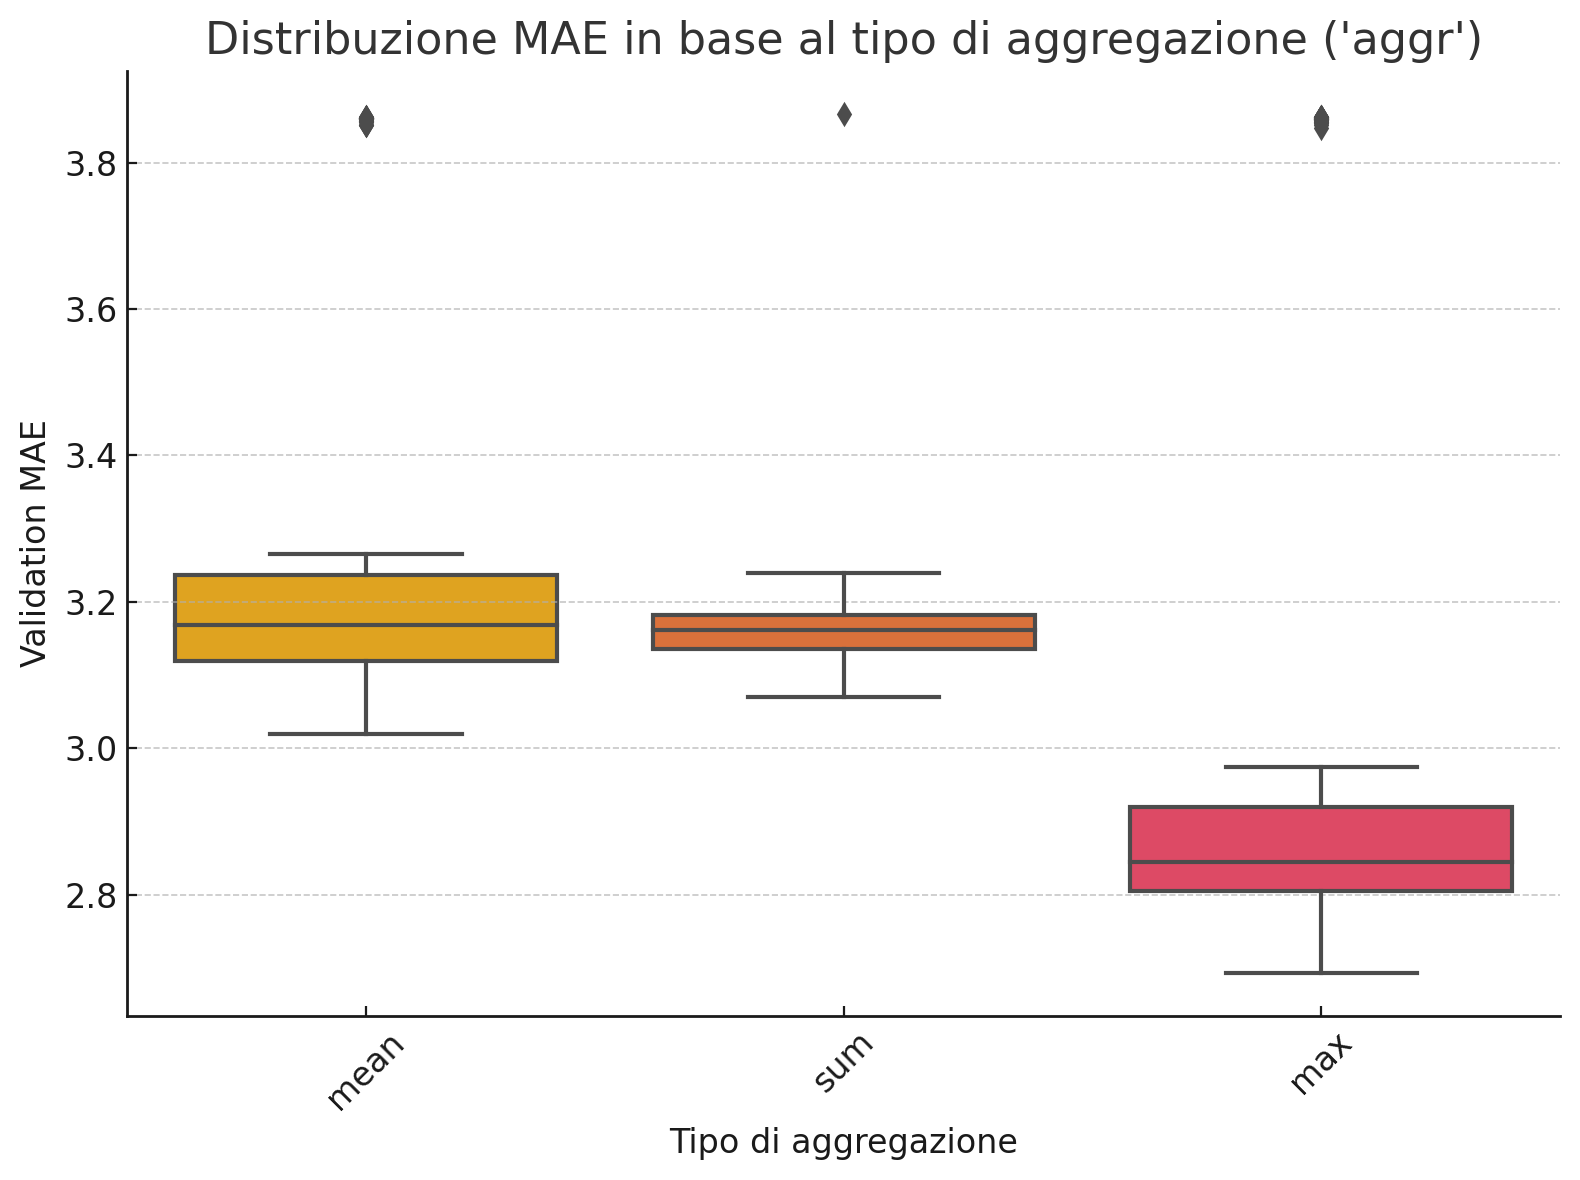

Configurazione migliore:
Params: lr=0.0005, wd=0, ch=256, nl=2, aggr=max, norm=batch_norm, batch_size=512, num_neighbours=256
Early stopping at epoch 33
Final validation MAE: 2.693

# Training loop

In [22]:
model = Model(
    data=data,
    col_stats_dict=col_stats_dict,
    num_layers=2,
    channels=128,
    out_channels=1,
    aggr="max",
    norm="batch_norm",
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=0
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=10,
    verbose=True
)

loader_dict = loader_dict_fn(batch_size=512, num_neighbours=256)


early_stopping = EarlyStopping(
    patience=30,
    delta=0.0,
    verbose=True,
    path="best_basic_model.pt"
)


epochs = 600
state_dict = None
test_table = task.get_table("test", mask_input_cols=False)
best_val_metric = -math.inf if higher_is_better else math.inf
best_test_metric = -math.inf if higher_is_better else math.inf
for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, loader_dict=loader_dict)

    train_pred = test(model, loader_dict["train"])
    train_metrics = evaluate_performance(train_pred, train_table, task.metrics)
    train_mae_preciso = evaluate_on_full_train(model, loader_dict["train"])

    val_pred = test(model, loader_dict["val"])
    val_metrics = evaluate_performance(val_pred, val_table, task.metrics)

    test_pred = test(model, loader_dict["test"])
    test_metrics = evaluate_performance(test_pred, test_table, task.metrics)

    scheduler.step(val_metrics[tune_metric])

    if (higher_is_better and val_metrics[tune_metric] > best_val_metric) or (
            not higher_is_better and val_metrics[tune_metric] < best_val_metric
    ):
        best_val_metric = val_metrics[tune_metric]
        state_dict = copy.deepcopy(model.state_dict())

    #test:
    if (higher_is_better and test_metrics[tune_metric] > best_test_metric) or (
            not higher_is_better and test_metrics[tune_metric] < best_test_metric
    ):
        best_test_metric = test_metrics[tune_metric]
        state_dict_test = copy.deepcopy(model.state_dict())

    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch:02d}, Train mae: {train_mae_preciso:.2f}, Validation MAE: {val_metrics[tune_metric]:.2f}, Test MAE: {test_metrics[tune_metric]:.2f}, LR: {current_lr:.6f}")

    early_stopping(val_metrics[tune_metric], model)

    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break
print(f"best validation results: {best_val_metric}")
print(f"best test results: {best_test_metric}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch: 01, Train mae: 13.94, Validation MAE: 11.08, Test MAE: 12.43, LR: 0.000500
Validation loss migliorata (inf --> 11.082749). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch: 02, Train mae: 12.86, Validation MAE: 9.79, Test MAE: 10.84, LR: 0.000500
Validation loss migliorata (11.082749 --> 9.791848). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.81it/s]


Epoch: 03, Train mae: 11.73, Validation MAE: 8.82, Test MAE: 9.74, LR: 0.000500
Validation loss migliorata (9.791848 --> 8.821112). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch: 04, Train mae: 11.40, Validation MAE: 8.47, Test MAE: 9.17, LR: 0.000500
Validation loss migliorata (8.821112 --> 8.467590). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.83it/s]


Epoch: 05, Train mae: 11.06, Validation MAE: 8.37, Test MAE: 8.88, LR: 0.000500
Validation loss migliorata (8.467590 --> 8.370477). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch: 06, Train mae: 10.86, Validation MAE: 8.27, Test MAE: 8.61, LR: 0.000500
Validation loss migliorata (8.370477 --> 8.274106). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.84it/s]


Epoch: 07, Train mae: 10.43, Validation MAE: 8.05, Test MAE: 8.43, LR: 0.000500
Validation loss migliorata (8.274106 --> 8.046181). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch: 08, Train mae: 9.55, Validation MAE: 7.71, Test MAE: 8.01, LR: 0.000500
Validation loss migliorata (8.046181 --> 7.707704). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


Epoch: 09, Train mae: 8.97, Validation MAE: 7.13, Test MAE: 7.47, LR: 0.000500
Validation loss migliorata (7.707704 --> 7.134116). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


Epoch: 10, Train mae: 9.27, Validation MAE: 6.78, Test MAE: 7.20, LR: 0.000500
Validation loss migliorata (7.134116 --> 6.776707). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.74it/s]


Epoch: 11, Train mae: 7.93, Validation MAE: 6.25, Test MAE: 6.90, LR: 0.000500
Validation loss migliorata (6.776707 --> 6.248801). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch: 12, Train mae: 8.59, Validation MAE: 5.42, Test MAE: 5.98, LR: 0.000500
Validation loss migliorata (6.248801 --> 5.422360). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.64it/s]


Epoch: 13, Train mae: 7.12, Validation MAE: 4.85, Test MAE: 5.57, LR: 0.000500
Validation loss migliorata (5.422360 --> 4.846682). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch: 14, Train mae: 7.46, Validation MAE: 5.06, Test MAE: 5.84, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch: 15, Train mae: 6.75, Validation MAE: 3.68, Test MAE: 5.03, LR: 0.000500
Validation loss migliorata (4.846682 --> 3.678515). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch: 16, Train mae: 6.38, Validation MAE: 4.44, Test MAE: 4.97, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


Epoch: 17, Train mae: 5.68, Validation MAE: 3.41, Test MAE: 4.51, LR: 0.000500
Validation loss migliorata (3.678515 --> 3.411208). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch: 18, Train mae: 5.06, Validation MAE: 3.29, Test MAE: 4.47, LR: 0.000500
Validation loss migliorata (3.411208 --> 3.291679). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


Epoch: 19, Train mae: 4.97, Validation MAE: 3.03, Test MAE: 4.01, LR: 0.000500
Validation loss migliorata (3.291679 --> 3.030194). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.33it/s]


Epoch: 20, Train mae: 4.62, Validation MAE: 3.30, Test MAE: 4.15, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch: 21, Train mae: 5.24, Validation MAE: 3.69, Test MAE: 4.27, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 15/15 [00:02<00:00,  5.42it/s]


Epoch: 22, Train mae: 5.13, Validation MAE: 3.56, Test MAE: 4.28, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 15/15 [00:02<00:00,  5.62it/s]


Epoch: 23, Train mae: 4.90, Validation MAE: 3.22, Test MAE: 4.10, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


Epoch: 24, Train mae: 3.84, Validation MAE: 3.13, Test MAE: 4.07, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


Epoch: 25, Train mae: 4.24, Validation MAE: 3.17, Test MAE: 4.04, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Epoch: 26, Train mae: 3.75, Validation MAE: 2.98, Test MAE: 4.17, LR: 0.000500
Validation loss migliorata (3.030194 --> 2.980075). Salvo modello...


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


Epoch: 27, Train mae: 3.87, Validation MAE: 3.32, Test MAE: 4.14, LR: 0.000500
EarlyStopping counter: 1 / 30


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Epoch: 28, Train mae: 3.69, Validation MAE: 3.73, Test MAE: 4.48, LR: 0.000500
EarlyStopping counter: 2 / 30


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch: 29, Train mae: 4.57, Validation MAE: 3.02, Test MAE: 4.26, LR: 0.000500
EarlyStopping counter: 3 / 30


100%|██████████| 15/15 [00:02<00:00,  5.37it/s]


Epoch: 30, Train mae: 4.50, Validation MAE: 3.06, Test MAE: 4.08, LR: 0.000500
EarlyStopping counter: 4 / 30


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch: 31, Train mae: 4.34, Validation MAE: 3.37, Test MAE: 4.22, LR: 0.000500
EarlyStopping counter: 5 / 30


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Epoch: 32, Train mae: 3.42, Validation MAE: 3.08, Test MAE: 4.15, LR: 0.000500
EarlyStopping counter: 6 / 30


100%|██████████| 15/15 [00:02<00:00,  5.58it/s]


Epoch: 33, Train mae: 3.17, Validation MAE: 3.18, Test MAE: 4.18, LR: 0.000500
EarlyStopping counter: 7 / 30


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


Epoch: 34, Train mae: 2.88, Validation MAE: 3.21, Test MAE: 4.14, LR: 0.000500
EarlyStopping counter: 8 / 30


100%|██████████| 15/15 [00:02<00:00,  5.62it/s]


Epoch: 35, Train mae: 2.91, Validation MAE: 3.39, Test MAE: 4.45, LR: 0.000500
EarlyStopping counter: 9 / 30


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]


Epoch: 36, Train mae: 4.33, Validation MAE: 3.47, Test MAE: 4.24, LR: 0.000500
EarlyStopping counter: 10 / 30


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


Epoch: 37, Train mae: 4.06, Validation MAE: 3.69, Test MAE: 4.40, LR: 0.000250
EarlyStopping counter: 11 / 30


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


Epoch: 38, Train mae: 2.61, Validation MAE: 3.21, Test MAE: 4.39, LR: 0.000250
EarlyStopping counter: 12 / 30


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


Epoch: 39, Train mae: 2.82, Validation MAE: 3.12, Test MAE: 4.27, LR: 0.000250
EarlyStopping counter: 13 / 30


100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


Epoch: 40, Train mae: 2.43, Validation MAE: 3.20, Test MAE: 4.25, LR: 0.000250
EarlyStopping counter: 14 / 30


100%|██████████| 15/15 [00:02<00:00,  5.49it/s]


Epoch: 41, Train mae: 2.56, Validation MAE: 3.33, Test MAE: 4.27, LR: 0.000250
EarlyStopping counter: 15 / 30


100%|██████████| 15/15 [00:02<00:00,  5.51it/s]


Epoch: 42, Train mae: 3.85, Validation MAE: 3.30, Test MAE: 4.37, LR: 0.000250
EarlyStopping counter: 16 / 30


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


Epoch: 43, Train mae: 3.19, Validation MAE: 3.24, Test MAE: 4.24, LR: 0.000250
EarlyStopping counter: 17 / 30


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


Epoch: 44, Train mae: 2.45, Validation MAE: 3.38, Test MAE: 4.24, LR: 0.000250
EarlyStopping counter: 18 / 30


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


Epoch: 45, Train mae: 2.89, Validation MAE: 3.31, Test MAE: 4.33, LR: 0.000250
EarlyStopping counter: 19 / 30


100%|██████████| 15/15 [00:02<00:00,  5.56it/s]


Epoch: 46, Train mae: 2.35, Validation MAE: 3.26, Test MAE: 4.20, LR: 0.000250
EarlyStopping counter: 20 / 30


100%|██████████| 15/15 [00:02<00:00,  5.61it/s]


Epoch: 47, Train mae: 2.38, Validation MAE: 3.25, Test MAE: 4.20, LR: 0.000250
EarlyStopping counter: 21 / 30


100%|██████████| 15/15 [00:02<00:00,  5.54it/s]


Epoch: 48, Train mae: 2.06, Validation MAE: 3.30, Test MAE: 4.28, LR: 0.000125
EarlyStopping counter: 22 / 30


100%|██████████| 15/15 [00:02<00:00,  5.57it/s]


Epoch: 49, Train mae: 2.05, Validation MAE: 3.29, Test MAE: 4.24, LR: 0.000125
EarlyStopping counter: 23 / 30


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch: 50, Train mae: 2.23, Validation MAE: 3.23, Test MAE: 4.20, LR: 0.000125
EarlyStopping counter: 24 / 30


100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


Epoch: 51, Train mae: 2.03, Validation MAE: 3.28, Test MAE: 4.32, LR: 0.000125
EarlyStopping counter: 25 / 30


100%|██████████| 15/15 [00:02<00:00,  5.40it/s]


Epoch: 52, Train mae: 2.25, Validation MAE: 3.37, Test MAE: 4.30, LR: 0.000125
EarlyStopping counter: 26 / 30


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


Epoch: 53, Train mae: 2.12, Validation MAE: 3.28, Test MAE: 4.23, LR: 0.000125
EarlyStopping counter: 27 / 30


100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


Epoch: 54, Train mae: 1.90, Validation MAE: 3.36, Test MAE: 4.18, LR: 0.000125
EarlyStopping counter: 28 / 30


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


Epoch: 55, Train mae: 1.86, Validation MAE: 3.32, Test MAE: 4.20, LR: 0.000125
EarlyStopping counter: 29 / 30


100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


Epoch: 56, Train mae: 1.85, Validation MAE: 3.34, Test MAE: 4.18, LR: 0.000125
EarlyStopping counter: 30 / 30
Early stopping triggered at epoch 56
best validation results: 2.980074761211673
best test results: 4.009003951967808


circa 2.76 validation results e 3.79 test results

# Loading the best model

In [23]:
#model.load_state_dict(torch.load("best_model.pt"))